## QB ADP Modelling

Predicting QB fantasy rank based on pre-season teammate ADPs

Scoring data and historic ADP from: https://fantasydata.com/nfl/fantasy-football-leaders

### 1. Data Prep

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# read in data
adp = pd.read_csv('ADP_14_19.csv', encoding = 'unicode_escape')
qb_pts = pd.read_csv('QB_perf.csv')

In [3]:
# filter QBs to those who played in at least 8 games
qb_pts = qb_pts[qb_pts['GMS'] > 7]

In [4]:
# add a column for fantasy points per game rank
qb_pts['FPPG_RK'] = 0

In [5]:
# sort and add fantasy points per game rank
qb_pts = qb_pts.sort_values(by = ['Year', 'FPTS/G'], ascending = [False, False])
qb_pts = qb_pts.reset_index(drop = True)
rank = 1
qb_pts.loc[0, 'FPPG_RK'] = 1
for i in range(1, len(qb_pts)):
    if qb_pts.loc[i, 'Year'] == qb_pts.loc[i - 1, 'Year']:
        rank += 1
    else:
        rank = 1
    qb_pts.loc[i, 'FPPG_RK'] = rank

In [6]:
qb_pts

,Year,RK,NAME,TEAM,POS,GMS,PassCMPs,PassATTs,PassPCT,PassYDS,...,PassTD,PassINT,PassRAT,RusATT,RusYDS,RusAVG,RusTD,FPTS/G,FPTS,FPPG_RK
0,2019,1,Lamar Jackson,BAL,QB,15,265,401,66.1,3127,...,36,6,113.34,176,1206,6.9,7,27.7,415.68,1
1,2019,4,Deshaun Watson,HOU,QB,15,333,495,67.3,3852,...,26,12,97.98,82,413,5.0,7,21.3,319.98,2
2,2019,2,Dak Prescott,DAL,QB,16,388,596,65.1,4902,...,30,11,99.69,52,277,5.3,3,21.1,337.78,3
3,2019,29,Matthew Stafford,DET,QB,8,187,291,64.3,2499,...,19,5,106.02,20,66,3.3,0,20.8,166.56,4
4,2019,3,Russell Wilson,SEA,QB,16,341,516,66.1,4110,...,31,5,106.33,75,342,4.6,3,20.5,328.60,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2014,28,Josh McCown,TB,QB,12,184,327,56.3,2206,...,11,14,70.46,25,127,5.1,3,10.6,126.94,30
202,2014,32,Drew Stanton,ARI,QB,9,132,240,55.0,1711,...,7,5,78.66,25,63,2.5,0,10.5,94.74,31
203,2014,34,Shaun Hill,LAR,QB,9,145,229,63.3,1657,...,8,7,83.91,10,10,1.0,1,9.9,89.28,32
204,2014,36,Robert Griffin III,WAS,QB,9,147,214,68.7,1694,...,4,6,86.86,38,176,4.6,1,9.7,87.36,33


In [7]:
# add column for team position ADP rank
adp['Team_RK'] = 'blank'

In [8]:
# initialize a vector for counts of each position and a list to index the vector
position_counts = np.zeros(7, dtype=int)
positions = ('QB', 'RB', 'WR', 'TE', 'K', 'DST', 'FB')

In [9]:
# sort ADP table by year by team by position by ADP
adp = adp.sort_values(by = ['Year', 'TEAM', 'POS', 'ADP'], ascending = [False, True, True, True])
adp = adp.reset_index(drop = True)

In [10]:
# identify the team position rank for each player for each year
adp.loc[0, 'Team_RK'] = 'DST1'
position_counts[:] = 0
for i in range(1, len(adp)):
    if adp.loc[i, 'TEAM'] == adp.loc[i - 1, 'TEAM']:
        position_counts[positions.index(adp.loc[i, 'POS'])] += 1
        adp.loc[i, 'Team_RK'] = adp.loc[i, 'POS'] + str(position_counts[positions.index(adp.loc[i, 'POS'])])
    else:
        position_counts[:] = 0
        adp.loc[i, 'Team_RK'] = adp.loc[i, 'POS'] + str(1)

In [11]:
adp['Team_RK'].unique()

array(['DST1', 'QB1', 'RB1', 'RB2', 'WR1', 'WR2', 'WR3', 'WR4', 'K1',
       'TE1', 'RB3', 'WR5', 'QB2', 'TE2', 'RB4', 'WR6', 'K2', 'FB1',
       'RB5'], dtype=object)

In [12]:
# add columns to QB data for teammate ADPs
qb_pts['RB1_ADP'] = 300
qb_pts['RB2_ADP'] = 300
qb_pts['WR1_ADP'] = 300
qb_pts['WR2_ADP'] = 300
qb_pts['WR3_ADP'] = 300
qb_pts['TE1_ADP'] = 300
qb_pts['TE2_ADP'] = 300
qb_pts['K1_ADP'] = 300

In [13]:
teammate_slots = ['RB1', 'RB2', 'WR1', 'WR2', 'WR3', 'TE1', 'TE2', 'K1']

In [14]:
# for each QB, look up the ADP of each teammate from that pre-season
for i in range(len(qb_pts)):
    for j in range(len(teammate_slots)):
        rank = adp[(adp['Year'] == qb_pts.loc[i, 'Year']) & (adp['TEAM'] == qb_pts.loc[i, 'TEAM']) & 
                   (adp['Team_RK'] == teammate_slots[j])]['ADP']
        if not rank.empty:
            qb_pts.iloc[i, 21+j] = rank.iloc[0]

In [15]:
qb_pts

,Year,RK,NAME,TEAM,POS,GMS,PassCMPs,PassATTs,PassPCT,PassYDS,...,FPTS,FPPG_RK,RB1_ADP,RB2_ADP,WR1_ADP,WR2_ADP,WR3_ADP,TE1_ADP,TE2_ADP,K1_ADP
0,2019,1,Lamar Jackson,BAL,QB,15,265,401,66.1,3127,...,415.68,1,39.7,120.7,163.9,193.0,200.0,142.1,300.0,149.7
1,2019,4,Deshaun Watson,HOU,QB,15,333,495,67.3,3852,...,319.98,2,51.7,70.4,7.0,81.6,146.2,300.0,300.0,162.9
2,2019,2,Dak Prescott,DAL,QB,16,388,596,65.1,4902,...,337.78,3,3.9,83.3,33.1,113.8,161.7,300.0,300.0,172.7
3,2019,29,Matthew Stafford,DET,QB,8,187,291,64.3,2499,...,166.56,4,28.5,160.8,47.1,105.3,194.0,126.1,300.0,173.8
4,2019,3,Russell Wilson,SEA,QB,16,341,516,66.1,4110,...,328.60,5,26.5,95.3,42.9,131.8,191.0,300.0,300.0,170.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2014,28,Josh McCown,TB,QB,12,184,327,56.3,2206,...,126.94,30,19.2,300.0,33.4,101.9,300.0,162.2,300.0,300.0
202,2014,32,Drew Stanton,ARI,QB,9,132,240,55.0,1711,...,94.74,31,22.4,300.0,41.8,47.2,184.1,300.0,300.0,300.0
203,2014,34,Shaun Hill,LAR,QB,9,145,229,63.3,1657,...,89.28,32,32.0,173.7,133.4,145.5,300.0,300.0,300.0,199.5
204,2014,36,Robert Griffin III,WAS,QB,9,147,214,68.7,1694,...,87.36,33,34.1,187.9,39.6,60.7,300.0,84.1,300.0,300.0


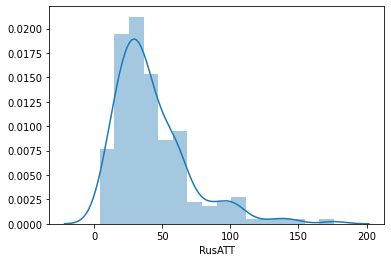

In [16]:
ax = sns.distplot(qb_pts['RusATT'])

In [17]:
qb_pts.loc[:,'RusATT'].var()

770.9663509353545

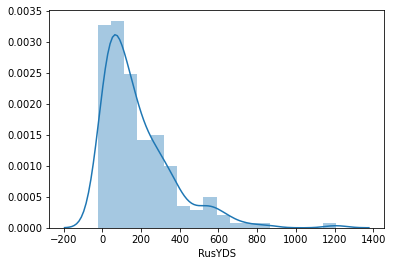

In [18]:
ax = sns.distplot(qb_pts['RusYDS'])

In [19]:
qb_pts.loc[:,'RusYDS'].var()

33525.67255505566

In [20]:
# create columns for last year rush yards and attempts
qb_pts['LY_RusATT'] = 0
qb_pts['LY_RusYDS'] = 0

In [21]:
# for each QB, look up their rushing yards and attempts from the previous season
for i in range(len(qb_pts)):
    row = qb_pts[(qb_pts['Year'] == qb_pts.loc[i, 'Year'] - 1) & (qb_pts['NAME'] == qb_pts.loc[i, 'NAME'])]
    if not row.empty:
        qb_pts.loc[i, 'LY_RusATT'] = row['RusATT'].iloc[0]
        qb_pts.loc[i, 'LY_RusYDS'] = row['RusYDS'].iloc[0]

In [22]:
qb_pts

,Year,RK,NAME,TEAM,POS,GMS,PassCMPs,PassATTs,PassPCT,PassYDS,...,RB1_ADP,RB2_ADP,WR1_ADP,WR2_ADP,WR3_ADP,TE1_ADP,TE2_ADP,K1_ADP,LY_RusATT,LY_RusYDS
0,2019,1,Lamar Jackson,BAL,QB,15,265,401,66.1,3127,...,39.7,120.7,163.9,193.0,200.0,142.1,300.0,149.7,147,695
1,2019,4,Deshaun Watson,HOU,QB,15,333,495,67.3,3852,...,51.7,70.4,7.0,81.6,146.2,300.0,300.0,162.9,99,551
2,2019,2,Dak Prescott,DAL,QB,16,388,596,65.1,4902,...,3.9,83.3,33.1,113.8,161.7,300.0,300.0,172.7,75,305
3,2019,29,Matthew Stafford,DET,QB,8,187,291,64.3,2499,...,28.5,160.8,47.1,105.3,194.0,126.1,300.0,173.8,25,71
4,2019,3,Russell Wilson,SEA,QB,16,341,516,66.1,4110,...,26.5,95.3,42.9,131.8,191.0,300.0,300.0,170.7,67,376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2014,28,Josh McCown,TB,QB,12,184,327,56.3,2206,...,19.2,300.0,33.4,101.9,300.0,162.2,300.0,300.0,0,0
202,2014,32,Drew Stanton,ARI,QB,9,132,240,55.0,1711,...,22.4,300.0,41.8,47.2,184.1,300.0,300.0,300.0,0,0
203,2014,34,Shaun Hill,LAR,QB,9,145,229,63.3,1657,...,32.0,173.7,133.4,145.5,300.0,300.0,300.0,199.5,0,0
204,2014,36,Robert Griffin III,WAS,QB,9,147,214,68.7,1694,...,34.1,187.9,39.6,60.7,300.0,84.1,300.0,300.0,0,0


In [23]:
# read in 2013 QB stats
qb_pts_13 = pd.read_csv('QB_perf13.csv', encoding = 'unicode_escape')

In [24]:
# add 2013 rushing stats to 2014 QB rows
for i in range(len(qb_pts)):
    if qb_pts.loc[i, 'Year'] == 2014:
        row = qb_pts_13[qb_pts_13['NAME'] == qb_pts.loc[i, 'NAME']]
        if not row.empty:
            qb_pts.loc[i, 'LY_RusATT'] = row['RusATT'].iloc[0]
            qb_pts.loc[i, 'LY_RusYDS'] = row['RusYDS'].iloc[0]

In [25]:
qb_pts[qb_pts['Year'] == 2014]

,Year,RK,NAME,TEAM,POS,GMS,PassCMPs,PassATTs,PassPCT,PassYDS,...,RB1_ADP,RB2_ADP,WR1_ADP,WR2_ADP,WR3_ADP,TE1_ADP,TE2_ADP,K1_ADP,LY_RusATT,LY_RusYDS
172,2014,1,Aaron Rodgers,GB,QB,16,341,520,65.6,4381,...,5.9,175.0,18.3,25.1,128.7,300.0,300.0,181.8,30,120
173,2014,2,Andrew Luck,IND,QB,16,380,616,61.7,4761,...,71.6,121.8,54.7,77.6,116.5,178.5,186.8,187.9,63,377
174,2014,3,Russell Wilson,SEA,QB,16,285,452,63.1,3475,...,14.4,144.2,47.4,164.7,193.7,300.0,300.0,166.6,96,539
175,2014,4,Peyton Manning,DEN,QB,16,395,597,66.2,4727,...,10.7,159.6,7.2,42.0,69.2,26.7,300.0,195.2,32,-31
176,2014,5,Ben Roethlisberger,PIT,QB,16,408,608,67.1,4952,...,28.0,133.2,18.2,121.7,300.0,133.6,300.0,300.0,26,99
177,2014,6,Drew Brees,NO,QB,16,456,659,69.2,4952,...,55.1,98.8,66.0,72.1,139.6,7.9,300.0,194.7,35,52
178,2014,7,Matt Ryan,ATL,QB,16,415,628,66.1,4694,...,86.7,103.9,13.6,34.2,188.6,300.0,300.0,300.0,17,55
179,2014,11,Tony Romo,DAL,QB,15,304,435,69.9,3705,...,13.3,128.4,9.4,86.7,300.0,68.3,300.0,181.7,20,38
180,2014,17,Cam Newton,CAR,QB,14,262,448,58.5,3127,...,111.9,137.0,85.0,300.0,300.0,88.1,300.0,300.0,111,585
181,2014,8,Ryan Tannehill,MIA,QB,16,392,590,66.4,4045,...,84.5,85.7,74.9,142.1,300.0,131.9,300.0,300.0,40,238


### 2. Data Exploration

[(0.0, 250.0)]

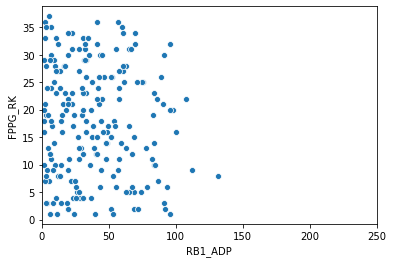

In [26]:
# view how individual teammate ADPs correlate to QB finish
ax = sns.scatterplot(x = 'RB1_ADP', y = 'FPPG_RK', data = qb_pts)
ax.set(xlim=(0, 250))

[(0.0, 250.0)]

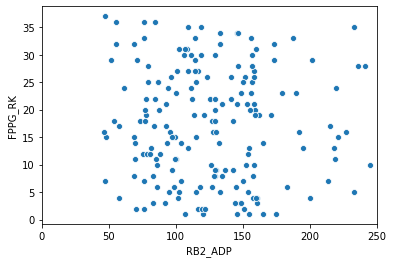

In [27]:
ax = sns.scatterplot(x = 'RB2_ADP', y = 'FPPG_RK', data = qb_pts)
ax.set(xlim=(0, 250))

[(0.0, 250.0)]

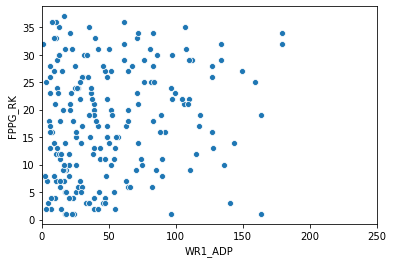

In [28]:
ax = sns.scatterplot(x = 'WR1_ADP', y = 'FPPG_RK', data = qb_pts)
ax.set(xlim=(0, 250))

[(0.0, 250.0)]

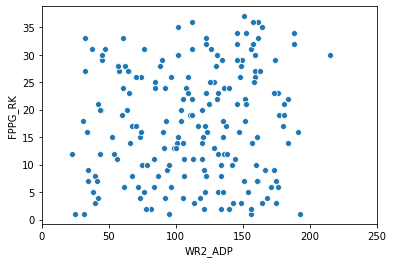

In [29]:
ax = sns.scatterplot(x = 'WR2_ADP', y = 'FPPG_RK', data = qb_pts)
ax.set(xlim=(0, 250))

[(0.0, 250.0)]

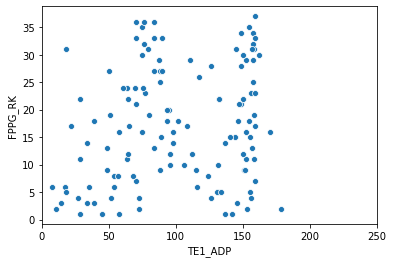

In [30]:
ax = sns.scatterplot(x = 'TE1_ADP', y = 'FPPG_RK', data = qb_pts)
ax.set(xlim=(0, 250))

[(0.0, 250.0)]

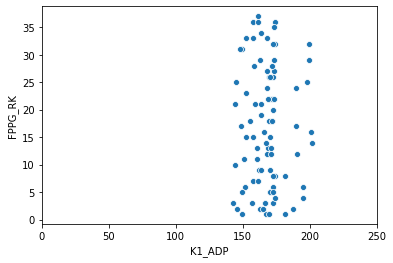

In [31]:
ax = sns.scatterplot(x = 'K1_ADP', y = 'FPPG_RK', data = qb_pts)
ax.set(xlim=(0, 250))

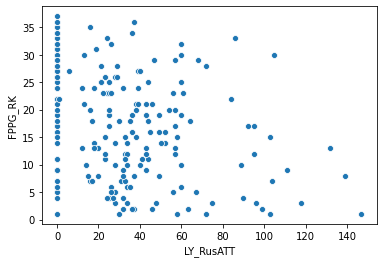

In [32]:
# view how previous year rushing attempts correlate to QB finish
ax = sns.scatterplot(x = 'LY_RusATT', y = 'FPPG_RK', data = qb_pts)

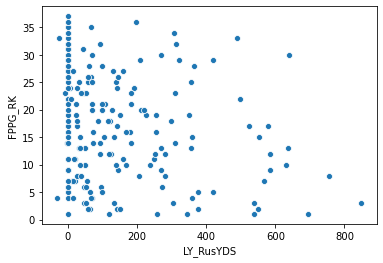

In [33]:
# view how previous year rushing yards correlate to QB finish
ax = sns.scatterplot(x = 'LY_RusYDS', y = 'FPPG_RK', data = qb_pts)

### 3. Modelling

In [34]:
import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#### Predict Fantasy Points Per Game Rank using Teammate ADPs

In [35]:
teammate_adps = ['RB1_ADP', 'RB2_ADP', 'WR1_ADP', 'WR2_ADP', 'TE1_ADP']

In [36]:
# create an X data set with the teammate ADPs
X = qb_pts[teammate_adps]

In [37]:
# create a y variable that is the fantasy points per game rank
y = qb_pts['FPPG_RK']

In [38]:
# split dataset into training and test sets
random_state = 12493
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = random_state)

In [39]:
# train a model on the unscaled data with just teammate ADPs
en_base = ElasticNet(alpha=0.1, l1_ratio=0.5)
en_base.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [40]:
# make predictions
preds_base = en_base.predict(X_test)
preds_base_train = en_base.predict(X_train)

In [41]:
# calculate model scores
rmse_base_train = np.sqrt(mean_squared_error(y_train, preds_base_train))
r2_base_train = r2_score(y_train, preds_base_train)
rmse_base_test = np.sqrt(mean_squared_error(y_test, preds_base))
r2_base_test = r2_score(y_test, preds_base)

In [42]:
print('Training RMSE:', rmse_base_train)
print('Training R2:', r2_base_train)
print('Test RMSE:', rmse_base_test)
print('Test R2:', r2_base_test)

Training RMSE: 9.90379096805001
Training R2: 0.07233264322905686
Test RMSE: 9.450938372129054
Test R2: -0.012799071471397472


#### Predict Fantasy Points Per Game Rank using scaled Teammate ADPs

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
# scale X data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# train a model on the scaled data with just teammate ADPs
en_scaled = ElasticNet(alpha=0.1, l1_ratio=0.5)
en_scaled.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.1)

In [46]:
# make predictions
preds_scaled = en_scaled.predict(X_test_scaled)
preds_scaled_train = en_scaled.predict(X_train_scaled)

In [47]:
# calculate model scores
rmse_scaled_train = np.sqrt(mean_squared_error(y_train, preds_scaled_train))
r2_scaled_train = r2_score(y_train, preds_scaled_train)
rmse_scaled_test = np.sqrt(mean_squared_error(y_test, preds_scaled))
r2_scaled_test = r2_score(y_test, preds_scaled)

In [48]:
print('Training RMSE:', rmse_scaled_train)
print('Training R2:', r2_scaled_train)
print('Test RMSE:', rmse_scaled_test)
print('Test R2:', r2_scaled_test)

Training RMSE: 9.905485131907733
Training R2: 0.07201523852306113
Test RMSE: 9.456417839848207
Test R2: -0.013973813782438782


#### Predict Fantasy Points Per Game Rank using scaled Teammate ADPs and Previous Season Rushing Yards

In [49]:
# add rushing yards to the independent variable set
adps_rusyards = ['RB1_ADP', 'RB2_ADP', 'WR1_ADP', 'WR2_ADP', 'TE1_ADP', 'LY_RusYDS']
X_ry = qb_pts[adps_rusyards]

In [50]:
X_train_ry, X_test_ry, y_train, y_test = sklearn.model_selection.train_test_split(X_ry, y, test_size = 0.2, random_state = random_state)

In [51]:
# scale X data
scaler_ry = StandardScaler()
X_train_ry_scaled = scaler_ry.fit_transform(X_train_ry)
X_test_ry_scaled = scaler_ry.transform(X_test_ry)

In [52]:
# train a model on the scaled data with teammate ADPs and last year rush yards
en_ry = ElasticNet(alpha=0.1, l1_ratio=0.5)
en_ry.fit(X_train_ry_scaled, y_train)

ElasticNet(alpha=0.1)

In [53]:
# make predictions
preds_ry = en_ry.predict(X_test_ry_scaled)
preds_ry_train = en_ry.predict(X_train_ry_scaled)

In [54]:
# calculate model scores
rmse_ry_train = np.sqrt(mean_squared_error(y_train, preds_ry_train))
r2_ry_train = r2_score(y_train, preds_ry_train)
rmse_ry_test = np.sqrt(mean_squared_error(y_test, preds_ry))
r2_ry_test = r2_score(y_test, preds_ry)

In [55]:
print('Training RMSE:', rmse_ry_train)
print('Training R2:', r2_ry_train)
print('Test RMSE:', rmse_ry_test)
print('Test R2:', r2_ry_test)

Training RMSE: 9.504172813237908
Training R2: 0.14013594468718693
Test RMSE: 8.552545295941188
Test R2: 0.11493227181796606


#### Predict Fantasy Points Per Game Rank using scaled Teammate ADPs and Previous Season Rush Attempts

In [56]:
# try again using rush attempts instead of yards
adps_rusatts = ['RB1_ADP', 'WR1_ADP', 'WR2_ADP', 'TE1_ADP', 'LY_RusATT']
X_ra = qb_pts[adps_rusatts]

In [57]:
X_train_ra, X_test_ra, y_train, y_test = sklearn.model_selection.train_test_split(X_ra, y, test_size = 0.2, random_state = random_state)

In [58]:
# scale X data
scaler_ra = StandardScaler()
X_train_ra_scaled = scaler_ra.fit_transform(X_train_ra)
X_test_ra_scaled = scaler_ra.transform(X_test_ra)

In [59]:
# train a model on the scaled data with teammate ADPs and last year rush attempts
en_ra = ElasticNet(alpha=0.1, l1_ratio=0.5)
en_ra.fit(X_train_ra_scaled, y_train)

ElasticNet(alpha=0.1)

In [60]:
# make predictions
preds_ra = en_ra.predict(X_test_ra_scaled)
preds_ra_train = en_ra.predict(X_train_ra_scaled)

In [61]:
# calculate model scores
rmse_ra_train = np.sqrt(mean_squared_error(y_train, preds_ra_train))
r2_ra_train = r2_score(y_train, preds_ra_train)
rmse_ra_test = np.sqrt(mean_squared_error(y_test, preds_ra))
r2_ra_test = r2_score(y_test, preds_ra)

In [62]:
print('Training RMSE:', rmse_ra_train)
print('Training R2:', r2_ra_train)
print('Test RMSE:', rmse_ra_test)
print('Test R2:', r2_ra_test)

Training RMSE: 9.255599385389653
Training R2: 0.1845257670892423
Test RMSE: 8.361977170875006
Test R2: 0.15393506786158995


#### Grid Search on Scaled Teammate ADPs and Previous Season Rush Attempts

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
# create a dictionary of parameters 
param_grid = {'alpha': [0.01, 0.1, 0.25, 0.5],
              'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]}

en_obj = ElasticNet()

In [65]:
# search through the combinations in the grid
en_ra_gs = GridSearchCV(en_obj, param_grid, cv = 5, scoring = 'r2', refit = True, n_jobs = -1, verbose = 4)
en_ra_gs.fit(X_train_ra_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.25, 0.5],
                         'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]},
             scoring='r2', verbose=4)

In [66]:
# see best parameters from the grid search
en_ra_gs.best_params_

{'alpha': 0.25, 'l1_ratio': 0.1}

In [67]:
# make predictions
preds_ra_gs = en_ra_gs.best_estimator_.predict(X_test_ra_scaled)
preds_ra_gs_train = en_ra_gs.best_estimator_.predict(X_train_ra_scaled)

In [68]:
# calculate model scores
rmse_ra_gs_train = np.sqrt(mean_squared_error(y_train, preds_ra_gs_train))
r2_ra_gs_train = r2_score(y_train, preds_ra_gs_train)
rmse_ra_gs_test = np.sqrt(mean_squared_error(y_test, preds_ra_gs))
r2_ra_gs_test = r2_score(y_test, preds_ra_gs)

In [69]:
print('Training RMSE:', rmse_ra_gs_train)
print('Training R2:', r2_ra_gs_train)
print('Test RMSE:', rmse_ra_gs_test)
print('Test R2:', r2_ra_gs_test)

Training RMSE: 9.285928083225745
Training R2: 0.17917272794866368
Test RMSE: 8.333180459853065
Test R2: 0.15975233692831703


#### XGBoost with random search

In [70]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [71]:
# create a dictionary of parameters 
param_grid = {'n_estimators':np.arange(100, 1050, 50),
              'learning_rate':np.arange(0.1, 1.7, 0.1),
              'max_depth':[1, 2, 3],
              'gamma':np.arange(0, 5.25, 0.25)}

# create a Gradient Boost regressor object
xgb_obj = xgb.XGBRegressor()

In [72]:
# search through a random selection of the combinations in the grid
xgb_rs = RandomizedSearchCV(xgb_obj, param_grid, cv = 5, scoring = 'r2', refit = True, n_jobs = -1, verbose = 4)
xgb_rs.fit(X_train_ra, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  40 out of  50 | elapsed:   13.6s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.4s finished


[10:37:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_jobs=-1,
                   param_distributions={'gamma': array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
                                        'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6]),
                                        'max_depth': [1, 2, 3],
                                        'n_estimators': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000])},
                   scoring='r2', verbose=4)

In [73]:
# see best parameters from the grid search
xgb_rs.best_params_

{'n_estimators': 300, 'max_depth': 1, 'learning_rate': 0.2, 'gamma': 3.5}

In [74]:
# make predictions
preds_ra_xgb = xgb_rs.best_estimator_.predict(X_test_ra)
preds_ra_xgb_train = xgb_rs.best_estimator_.predict(X_train_ra)

In [75]:
# calculate model scores
rmse_ra_xgb_train = np.sqrt(mean_squared_error(y_train, preds_ra_xgb_train))
r2_ra_xgb_train = r2_score(y_train, preds_ra_xgb_train)
rmse_ra_xgb_test = np.sqrt(mean_squared_error(y_test, preds_ra_xgb))
r2_ra_xgb_test = r2_score(y_test, preds_ra_xgb)

In [76]:
print('Training RMSE:', rmse_ra_xgb_train)
print('Training R2:', r2_ra_xgb_train)
print('Test RMSE:', rmse_ra_xgb_test)
print('Test R2:', r2_ra_xgb_test)

Training RMSE: 6.818183251902093
Training R2: 0.5574743131080989
Test RMSE: 9.090981279239271
Test R2: -1.673185005857114e-05


#### XGBoost with early stopping

In [77]:
# create eval_set parameter for early stopping evaluation
eval_set = [(X_train_ra, y_train), (X_test_ra, y_test)]

In [78]:
# fit the model using early stopping
xgb_es = xgb.XGBRegressor(max_depth = 2, n_estimators = 750)
xgb_es.fit(X_train_ra, y_train, eval_set=eval_set, early_stopping_rounds=10)

[10:37:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:18.6001	validation_1-rmse:17.4583
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:17.2168	validation_1-rmse:16.1065
[2]	validation_0-rmse:15.9983	validation_1-rmse:14.8896
[3]	validation_0-rmse:14.9309	validation_1-rmse:13.8753
[4]	validation_0-rmse:13.9982	validation_1-rmse:13.0044
[5]	validation_0-rmse:13.1883	validation_1-rmse:12.2522
[6]	validation_0-rmse:12.4849	validation_1-rmse:11.5768
[7]	validation_0-rmse:11.8632	validation_1-rmse:11.088
[8]	validation_0-rmse:11.3244	validation_1-rmse:10.6788
[9]	validation_0-rmse:10.8676	validation_1-rmse:10.2437
[10]	validation_0-rmse:10.4679	validation_1-rmse:9.93302
[11]	validation_0-rmse:10.1197	validation_1-rmse:9.6189
[12]	

XGBRegressor(max_depth=2, n_estimators=750)

In [79]:
# make predictions
preds_xgb_es = xgb_es.predict(X_test_ra, ntree_limit = xgb_es.best_ntree_limit)
preds_xgb_es_train = xgb_es.predict(X_train_ra, ntree_limit = xgb_es.best_ntree_limit)

In [80]:
# calculate model scores
rmse_xgb_es_train = np.sqrt(mean_squared_error(y_train, preds_xgb_es_train))
r2_xgb_es_train = r2_score(y_train, preds_xgb_es_train)
rmse_xgb_es_test = np.sqrt(mean_squared_error(y_test, preds_xgb_es))
r2_xgb_es_test = r2_score(y_test, preds_xgb_es)

In [81]:
print('Training RMSE:', rmse_xgb_es_train)
print('Training R2:', r2_xgb_es_train)
print('Test RMSE:', rmse_xgb_es_test)
print('Test R2:', r2_xgb_es_test)

Training RMSE: 7.545405373097023
Training R2: 0.45804116600322664
Test RMSE: 8.619288936196952
Test R2: 0.101064320234581


In [82]:
print('min', min(preds_xgb_es))
print('max', max(preds_xgb_es))

min 5.5892572
max 25.43578


### Predicting Points per Game rather than PPG Rank

In [83]:
# create a y variable that is the fantasy points per game rank
y = qb_pts['FPTS/G']

In [84]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_ra, y, test_size = 0.2, random_state = random_state)

In [85]:
# scale X data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [86]:
# create a dictionary of parameters 
param_grid = {'alpha': [0.01, 0.1, 0.25, 0.5],
              'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]}

en_obj = ElasticNet()

In [87]:
# search through all combinations in the grid
en_pts_gs = GridSearchCV(en_obj, param_grid, cv = 5, scoring = 'r2', refit = True, n_jobs = -1, verbose = 4)
en_pts_gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.25, 0.5],
                         'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]},
             scoring='r2', verbose=4)

In [88]:
# see best parameters from the grid search
en_pts_gs.best_params_

{'alpha': 0.25, 'l1_ratio': 0.9}

In [89]:
# make predictions
preds_pts_gs = en_pts_gs.best_estimator_.predict(X_test_scaled)
preds_pts_gs_train = en_pts_gs.best_estimator_.predict(X_train_scaled)

In [90]:
# calculate model scores
rmse_pts_gs_train = np.sqrt(mean_squared_error(y_train, preds_pts_gs_train))
r2_pts_gs_train = r2_score(y_train, preds_pts_gs_train)
rmse_pts_gs_test = np.sqrt(mean_squared_error(y_test, preds_pts_gs))
r2_pts_gs_test = r2_score(y_test, preds_pts_gs)

In [91]:
print('Training RMSE:', rmse_pts_gs_train)
print('Training R2:', r2_pts_gs_train)
print('Test RMSE:', rmse_pts_gs_test)
print('Test R2:', r2_pts_gs_test)

Training RMSE: 3.9843862333301243
Training R2: 0.18751020952929043
Test RMSE: 3.088405835250488
Test R2: 0.030489088537843156


In [92]:
print('min', min(preds_pts_gs))
print('max', max(preds_pts_gs))

min 13.139473908865662
max 21.082262069046884


#### Predict points per game rank using early stopping XGBoost

In [93]:
# create eval_set parameter for early stopping evaluation
eval_set = [(X_train, y_train), (X_test, y_test)]

In [94]:
# fit the model using early stopping
xgb_pts_es = xgb.XGBRegressor(max_depth = 2, n_estimators = 750)
xgb_pts_es.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10)

[10:37:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14.2583	validation_1-rmse:14.2025
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:12.9641	validation_1-rmse:12.8913
[2]	validation_0-rmse:11.8092	validation_1-rmse:11.717
[3]	validation_0-rmse:10.7802	validation_1-rmse:10.6684
[4]	validation_0-rmse:9.86415	validation_1-rmse:9.73338
[5]	validation_0-rmse:9.04804	validation_1-rmse:8.92031
[6]	validation_0-rmse:8.32499	validation_1-rmse:8.17935
[7]	validation_0-rmse:7.68296	validation_1-rmse:7.54296
[8]	validation_0-rmse:7.11601	validation_1-rmse:6.93766
[9]	validation_0-rmse:6.61259	validation_1-rmse:6.43753
[10]	validation_0-rmse:6.17467	validation_1-rmse:5.99029
[11]	validation_0-rmse:5.78936	validation_1-rmse:5.61165
[12]

XGBRegressor(max_depth=2, n_estimators=750)

In [95]:
# make predictions
preds_xgb_pts_es = xgb_pts_es.predict(X_test, ntree_limit = xgb_pts_es.best_ntree_limit)
preds_xgb_pts_es_train = xgb_pts_es.predict(X_train, ntree_limit = xgb_pts_es.best_ntree_limit)

In [96]:
# calculate model scores
rmse_xgb_pts_es_train = np.sqrt(mean_squared_error(y_train, preds_xgb_pts_es_train))
r2_xgb_pts_es_train = r2_score(y_train, preds_xgb_pts_es_train)
rmse_xgb_pts_es_test = np.sqrt(mean_squared_error(y_test, preds_xgb_pts_es))
r2_xgb_pts_es_test = r2_score(y_test, preds_xgb_pts_es)

In [97]:
print('Training RMSE:', rmse_xgb_pts_es_train)
print('Training R2:', r2_xgb_pts_es_train)
print('Test RMSE:', rmse_xgb_pts_es_test)
print('Test R2:', r2_xgb_pts_es_test)

Training RMSE: 3.0318002939888857
Training R2: 0.5295686756280584
Test RMSE: 3.2175697806860146
Test R2: -0.05230085037292187


In [98]:
whole_set = qb_pts[['Year', 'NAME', 'RB1_ADP', 'WR1_ADP', 'WR2_ADP', 'TE1_ADP', 'LY_RusATT', 'FPTS/G', 'FPPG_RK']].copy()

In [99]:
preds_ws = xgb_pts_es.predict(whole_set.drop(columns = ['Year', 'NAME', 'FPTS/G', 'FPPG_RK']), 
                              ntree_limit = xgb_pts_es.best_ntree_limit)

In [100]:
whole_set['pred_pts'] = preds_ws

In [101]:
whole_set

,Year,NAME,RB1_ADP,WR1_ADP,WR2_ADP,TE1_ADP,LY_RusATT,FPTS/G,FPPG_RK,pred_pts
0,2019,Lamar Jackson,39.7,163.9,193.0,142.1,147,27.7,1,22.997807
1,2019,Deshaun Watson,51.7,7.0,81.6,300.0,99,21.3,2,18.564001
2,2019,Dak Prescott,3.9,33.1,113.8,300.0,75,21.1,3,17.279238
3,2019,Matthew Stafford,28.5,47.1,105.3,126.1,25,20.8,4,17.599466
4,2019,Russell Wilson,26.5,42.9,131.8,300.0,67,20.5,5,17.279238
...,...,...,...,...,...,...,...,...,...,...
201,2014,Josh McCown,19.2,33.4,101.9,162.2,13,10.6,30,14.114608
202,2014,Drew Stanton,22.4,41.8,47.2,300.0,0,10.5,31,14.708220
203,2014,Shaun Hill,32.0,133.4,145.5,300.0,0,9.9,32,11.984920
204,2014,Robert Griffin III,34.1,39.6,60.7,84.1,86,9.7,33,14.228549


In [102]:
# sort and add predicted fantasy points per game rank
whole_set = whole_set.sort_values(by = ['Year', 'pred_pts'], ascending = [False, False])
whole_set = whole_set.reset_index(drop = True)
whole_set['pred_rk'] = 0
rank = 1
whole_set.loc[0, 'pred_rk'] = 1
for i in range(1, len(whole_set)):
    if whole_set.loc[i, 'Year'] == whole_set.loc[i - 1, 'Year']:
        rank += 1
    else:
        rank = 1
    whole_set.loc[i, 'pred_rk'] = rank

In [103]:
whole_set

,Year,NAME,RB1_ADP,WR1_ADP,WR2_ADP,TE1_ADP,LY_RusATT,FPTS/G,FPPG_RK,pred_pts,pred_rk
0,2019,Lamar Jackson,39.7,163.9,193.0,142.1,147,27.7,1,22.997807,1
1,2019,Patrick Mahomes,25.5,13.9,96.1,17.1,60,20.5,6,19.321493,2
2,2019,Deshaun Watson,51.7,7.0,81.6,300.0,99,21.3,2,18.564001,3
3,2019,Carson Wentz,59.0,71.9,119.4,33.5,34,17.2,14,18.397371,4
4,2019,Kirk Cousins,14.6,22.9,30.8,154.9,44,16.3,18,18.298138,5
...,...,...,...,...,...,...,...,...,...,...,...
201,2014,Blake Bortles,42.8,126.8,148.3,300.0,0,12.0,26,11.984920,30
202,2014,Austin Davis,32.0,133.4,145.5,300.0,0,10.8,29,11.984920,31
203,2014,Shaun Hill,32.0,133.4,145.5,300.0,0,9.9,32,11.984920,32
204,2014,Derek Carr,70.8,158.8,300.0,300.0,0,12.0,25,11.381838,33


In [104]:
# calculate model scores
rmse_pts_rk = np.sqrt(mean_squared_error(whole_set['FPPG_RK'], whole_set['pred_rk']))
r2_pts_rk = r2_score(whole_set['FPPG_RK'], whole_set['pred_rk'])

In [105]:
print('RMSE:', rmse_pts_rk)
print('R2:', r2_pts_rk)

RMSE: 8.255624737463862
R2: 0.3221924644930504


### Clustering

In [106]:
from sklearn.cluster import KMeans

In [107]:
adps_rusatts = ['RB1_ADP', 'WR1_ADP', 'WR2_ADP', 'TE1_ADP', 'LY_RusATT']
X = qb_pts[adps_rusatts]

In [108]:
# cluster data using different number of clusters
random_state = 200829
clust2 = KMeans(n_clusters=2, random_state=random_state).fit(X)
clust3 = KMeans(n_clusters=3, random_state=random_state).fit(X)
clust4 = KMeans(n_clusters=4, random_state=random_state).fit(X)
clust5 = KMeans(n_clusters=5, random_state=random_state).fit(X)

In [109]:
cluster_score = pd.DataFrame({'clusters': [2, 3, 4, 5],
                              'inertia': [clust2.inertia_, clust3.inertia_, clust4.inertia_, clust5.inertia_]})

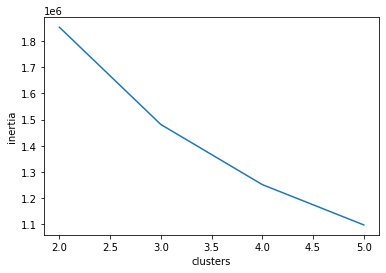

In [110]:
ax = sns.lineplot(x = 'clusters', y = 'inertia', data = cluster_score)

In [111]:
clust4.cluster_centers_

array([[ 38.31016949,  66.7559322 , 162.63728814, 109.84237288,
         36.06779661],
       [ 33.77857143,  38.71428571,  96.98571429, 299.33928571,
         33.05357143],
       [ 38.28142857,  29.46285714,  83.88428571,  93.75      ,
         30.37142857],
       [ 51.08571429, 125.95714286, 217.92380952, 300.        ,
         17.66666667]])

In [112]:
clust3.cluster_centers_

array([[ 38.07698413,  43.91825397, 117.39285714,  99.84206349,
         33.55555556],
       [ 50.62916667, 129.68333333, 218.85      , 281.79583333,
         16.54166667],
       [ 33.77857143,  38.71428571,  96.98571429, 299.33928571,
         33.05357143]])

In [113]:
qb_clusters = X.copy()

In [114]:
qb_clusters['name'] = qb_pts['NAME']
qb_clusters['cluster'] = clust4.labels_
qb_clusters['rank'] = qb_pts['FPPG_RK']

In [115]:
qb_clusters

,RB1_ADP,WR1_ADP,WR2_ADP,TE1_ADP,LY_RusATT,name,cluster,rank
0,39.7,163.9,193.0,142.1,147,Lamar Jackson,0,1
1,51.7,7.0,81.6,300.0,99,Deshaun Watson,1,2
2,3.9,33.1,113.8,300.0,75,Dak Prescott,1,3
3,28.5,47.1,105.3,126.1,25,Matthew Stafford,2,4
4,26.5,42.9,131.8,300.0,67,Russell Wilson,1,5
...,...,...,...,...,...,...,...,...
201,19.2,33.4,101.9,162.2,13,Josh McCown,2,30
202,22.4,41.8,47.2,300.0,0,Drew Stanton,1,31
203,32.0,133.4,145.5,300.0,0,Shaun Hill,3,32
204,34.1,39.6,60.7,84.1,86,Robert Griffin III,2,33


In [116]:
qb_clusters.groupby(by='cluster').mean()

,RB1_ADP,WR1_ADP,WR2_ADP,TE1_ADP,LY_RusATT,rank
cluster,,,,,,
0,38.310169,66.755932,162.637288,109.842373,36.067797,18.627119
1,33.778571,38.714286,96.985714,299.339286,33.053571,16.482143
2,38.281429,29.462857,83.884286,93.750000,30.371429,15.828571
3,51.085714,125.957143,217.923810,300.000000,17.666667,24.952381


### 4. Apply to 2020

In [117]:
# read in 2020 ADP data
adp_2020 = pd.read_csv('ADP_20.csv', encoding = 'unicode_escape')

In [118]:
# filter to just the QBs
qb_20 = adp_2020[adp_2020['POS'] == 'QB'].copy()
qb_20 = qb_20.reset_index(drop = True)

In [119]:
# create a column for the QB ADP rank
qb_20['ADP_RK'] = 0
for i in range(len(qb_20)):
    qb_20.loc[i, 'ADP_RK'] = i + 1

In [120]:
# add column for team position ADP rank
adp_2020['Team_RK'] = 'blank'

In [121]:
# initialize a vector for counts of each position and a list to index the vector
position_counts = np.zeros(7, dtype=int)
positions = ('QB', 'RB', 'WR', 'TE', 'K', 'DST', 'FB')

In [122]:
# sort ADP table by team by position by ADP
adp_2020 = adp_2020.sort_values(by = ['TEAM', 'POS', 'ADP'], ascending = [True, True, True])
adp_2020 = adp_2020.reset_index(drop = True)

In [123]:
adp_2020

,RK,NAME,TEAM,BYE,AGE,POS,POS RK,PTS,ADP,Team_RK
0,196,Zane Gonzalez,ARI,8,25.0,K,K7,100.00,166.2,blank
1,66,Kyler Murray,ARI,8,23.0,QB,QB5,299.22,62.6,blank
2,14,Kenyan Drake,ARI,8,26.0,RB,RB11,243.60,13.6,blank
3,114,Chase Edmonds,ARI,8,24.0,RB,RB47,56.30,110.6,blank
4,291,Eno Benjamin,ARI,8,21.0,RB,RB86,48.00,250.0,blank
...,...,...,...,...,...,...,...,...,...,...
295,278,J.D. McKissic,WAS,8,27.0,RB,RB82,52.20,237.0,blank
296,55,Terry McLaurin,WAS,8,24.0,WR,WR23,212.30,54.3,blank
297,231,Steven Sims Jr.,WAS,8,23.0,WR,WR79,115.10,190.0,blank
298,244,Antonio Gandy-Golden,WAS,8,22.0,WR,WR87,90.20,203.0,blank


In [124]:
# identify the team position rank for each player
adp_2020.loc[0, 'Team_RK'] = 'K1'
position_counts[:] = 0
for i in range(1, len(adp_2020)):
    if adp_2020.loc[i, 'TEAM'] == adp_2020.loc[i - 1, 'TEAM']:
        position_counts[positions.index(adp_2020.loc[i, 'POS'])] += 1
        adp_2020.loc[i, 'Team_RK'] = adp_2020.loc[i, 'POS'] + str(position_counts[positions.index(adp_2020.loc[i, 'POS'])])
    else:
        position_counts[:] = 0
        adp_2020.loc[i, 'Team_RK'] = adp_2020.loc[i, 'POS'] + str(1)

In [125]:
adp_2020

,RK,NAME,TEAM,BYE,AGE,POS,POS RK,PTS,ADP,Team_RK
0,196,Zane Gonzalez,ARI,8,25.0,K,K7,100.00,166.2,K1
1,66,Kyler Murray,ARI,8,23.0,QB,QB5,299.22,62.6,QB1
2,14,Kenyan Drake,ARI,8,26.0,RB,RB11,243.60,13.6,RB1
3,114,Chase Edmonds,ARI,8,24.0,RB,RB47,56.30,110.6,RB2
4,291,Eno Benjamin,ARI,8,21.0,RB,RB86,48.00,250.0,RB3
...,...,...,...,...,...,...,...,...,...,...
295,278,J.D. McKissic,WAS,8,27.0,RB,RB82,52.20,237.0,RB5
296,55,Terry McLaurin,WAS,8,24.0,WR,WR23,212.30,54.3,WR1
297,231,Steven Sims Jr.,WAS,8,23.0,WR,WR79,115.10,190.0,WR2
298,244,Antonio Gandy-Golden,WAS,8,22.0,WR,WR87,90.20,203.0,WR3


In [126]:
# add columns to QB data for teammate ADPs
qb_20['RB1_ADP'] = 300
qb_20['WR1_ADP'] = 300
qb_20['WR2_ADP'] = 300
qb_20['TE1_ADP'] = 300

In [127]:
teammate_slots = ['RB1', 'WR1', 'WR2', 'TE1']

In [128]:
# for each QB, look up the ADP of each teammate from pre-season
for i in range(len(qb_20)):
    for j in range(len(teammate_slots)):
        rank = adp_2020[(adp_2020['TEAM'] == qb_20.loc[i, 'TEAM']) & (adp_2020['Team_RK'] == teammate_slots[j])]['ADP']
        if not rank.empty:
            qb_20.iloc[i, 10 + j] = rank.iloc[0]

In [129]:
# add a column for last year's rush attempts
qb_20['LY_RusATT'] = 0

In [130]:
# for each QB, look up their rushing yards and attempts from 2019
for i in range(len(qb_20)):
    row = qb_pts[(qb_pts['Year'] == 2019) & (qb_pts['NAME'] == qb_20.loc[i, 'NAME'])]
    if not row.empty:
        qb_20.loc[i, 'LY_RusATT'] = row['RusATT'].iloc[0]

In [131]:
qb_20 = qb_20.drop(columns = ['RK', 'TEAM', 'BYE', 'AGE', 'POS', 'POS RK', 'PTS'])

In [132]:
qb_20

,NAME,ADP,ADP_RK,RB1_ADP,WR1_ADP,WR2_ADP,TE1_ADP,LY_RusATT
0,Patrick Mahomes,18.6,1,6.6,11.9,105.2,20.0,43
1,Lamar Jackson,21.1,2,46.7,64.5,205.0,44.3,176
2,Russell Wilson,57.4,3,29.3,46.9,51.2,300.0,75
3,Dak Prescott,61.2,4,4.0,38.2,78.6,154.1,52
4,Kyler Murray,62.6,5,13.6,17.6,116.4,300.0,93
5,Deshaun Watson,68.3,6,31.6,75.2,78.3,300.0,82
6,Drew Brees,79.5,7,4.7,6.0,96.7,112.4,9
7,Matt Ryan,84.4,8,29.3,15.1,41.3,81.3,34
8,Tom Brady,90.2,9,58.6,21.2,27.3,72.0,26
9,Aaron Rodgers,93.8,10,19.0,10.1,141.3,300.0,46


In [134]:
# use model to predict points per game rank
preds_20 = xgb_pts_es.predict(qb_20.drop(columns = ['NAME', 'ADP', 'ADP_RK']), 
                              ntree_limit = xgb_pts_es.best_ntree_limit)

In [135]:
qb_20['pred_pts'] = preds_20

In [136]:
# sort and add predicted fantasy points per game rank
qb_20 = qb_20.sort_values(by = ['pred_pts'], ascending = False)
qb_20 = qb_20.reset_index(drop = True)
qb_20['Predicted_RK'] = 0
for i in range(len(qb_20)):
    qb_20.loc[i, 'Predicted_RK'] = i + 1

In [137]:
qb_20['Diff'] = qb_20['Predicted_RK'] - qb_20['ADP_RK']

In [143]:
qb_20

,NAME,ADP,ADP_RK,RB1_ADP,WR1_ADP,WR2_ADP,TE1_ADP,LY_RusATT,pred_pts,Predicted_RK,Diff
0,Lamar Jackson,21.1,2,46.7,64.5,205.0,44.3,176,24.096001,1,-1
1,Jimmy Garoppolo,157.2,21,50.3,90.4,133.9,23.6,46,19.385725,2,-19
2,Patrick Mahomes,18.6,1,6.6,11.9,105.2,20.0,43,18.921864,3,2
3,Josh Allen,99.9,11,42.7,64.6,149.1,300.0,109,17.944313,4,-7
4,Carson Wentz,104.0,12,9.8,118.4,129.8,51.8,62,17.875639,5,-7
5,Baker Mayfield,137.1,17,15.7,34.5,81.5,135.6,28,17.752941,6,-11
6,Dak Prescott,61.2,4,4.0,38.2,78.6,154.1,52,17.535727,7,3
7,Kyler Murray,62.6,5,13.6,17.6,116.4,300.0,93,17.385561,8,3
8,Aaron Rodgers,93.8,10,19.0,10.1,141.3,300.0,46,16.921373,9,-1
9,Russell Wilson,57.4,3,29.3,46.9,51.2,300.0,75,16.883572,10,7


In [141]:
qb_20.loc[:, ['NAME', 'ADP_RK', 'Predicted_RK', 'Diff']].sort_values(by = ['Diff'])

,NAME,ADP_RK,Predicted_RK,Diff
1,Jimmy Garoppolo,21,2,-19
10,Kirk Cousins,24,11,-13
13,Derek Carr,27,14,-13
15,Sam Darnold,28,16,-12
5,Baker Mayfield,17,6,-11
23,Nick Foles,32,24,-8
11,Ryan Tannehill,20,12,-8
3,Josh Allen,11,4,-7
4,Carson Wentz,12,5,-7
18,Gardner Minshew II,26,19,-7
